# How does alcohol abuse affect your brain?

## Problem description

We were tasked with examining EEG data to determine wether there is an effect of alcohol abuse on the observed brain waves.

The dataset we are working on arises from a large study to examine how EEG correlates to genetic predisposition to alcoholism. It contains measurements from 64 electrodes placed on subject's scalps which were sampled at 256 Hz (3.9-msec epoch) for 1 second.

There were two groups of subjects: alcoholic and control. Each subject was exposed to either a single stimulus (S1) or to two stimuli (S1 and S2) which were pictures of objects chosen from the 1980 Snodgrass and Vanderwart picture set. When two stimuli were shown, they were presented in either a matched condition where S1 was identical to S2 or in a non-matched condition where S1 differed from S2.

Electroencephalogram (EEG) is a test that is used to detect abnormalities in brain waves, or the electrical activity of the brain. During the procedure, electrodes consisting of small metal discs with thin wires are pasted onto the scalp. The electrodes detect tiny electrical charges that result from the activity of the brain cells. The charges are amplified and appear as a graph on a computer screen, or as a recording that may be printed out on paper. 

Usually the case is that a healthcare provider then interprets the reading. However, as modern technology grows, AI tools have started to take over.

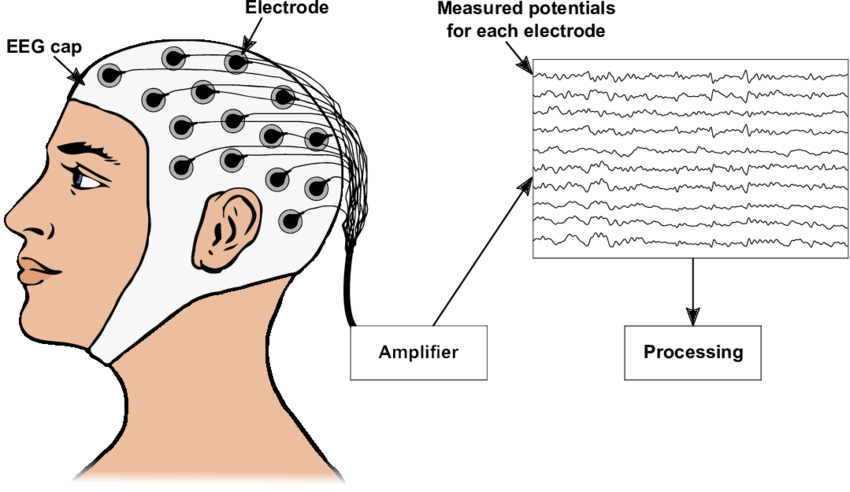

Data attribute information

Each trial is stored in its own file and will appear in the following format.

trial number sensor position sample num sensor value subject identifier matching condition channel name time

0 FP1 0 -8.921 a S1 obj 0 co2a0000364 0

0 AF8 87 4.14 a S1 obj 33 co2a0000364 0.33

The columns of data are:

the trial number,

sensor position,

sample number (0-255),

sensor value (in micro volts),

subject identifier(Alcoholic(a) or Control (c)),

matching condition(a single object shown (S1 obj), object 2 shown in a matching condition (S2 match), and object 2 shown in non matching condition (S2 nomatch)),

channel number(0-63),

name(a serial code assigned to each subject),

time(inverse of sample num measured in seconds))

Acknowledgements

There are no usage restrictions on this data.

Acknowledgments for this data should made to Henri Begleiter at the Neurodynamics Laboratory at the State University of New York Health Center at Brooklyn.

You can check out more info about it on: https://archive.ics.uci.edu/ml/datasets/eeg+database

References:
 - [1] Understanding alcohol use disorders with neuroelectrophysiology: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4331067/

## First look at the data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('SMNI_CMI_TEST\Data1.csv')

In [3]:
data.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,30,FP1,0,-3.550,a,S1 obj,0,co2a0000364,0.000000
1,6,30,FP1,1,-5.015,a,S1 obj,0,co2a0000364,0.003906
2,7,30,FP1,2,-5.503,a,S1 obj,0,co2a0000364,0.007812
3,8,30,FP1,3,-3.550,a,S1 obj,0,co2a0000364,0.011719
4,9,30,FP1,4,-0.621,a,S1 obj,0,co2a0000364,0.015625


In [4]:
data.describe()

,Unnamed: 0,trial number,sample num,sensor value,channel,time
count,16384.000000,16384.0,16384.000000,16384.000000,16384.000000,16384.000000
mean,8228.000000,30.0,127.500000,-0.008575,31.500000,0.498047
std,4748.269011,0.0,73.902526,6.754393,18.473517,0.288682
min,5.000000,30.0,0.000000,-48.330000,0.000000,0.000000
25%,4116.500000,30.0,63.750000,-4.059000,15.750000,0.249023
50%,8228.000000,30.0,127.500000,-0.285000,31.500000,0.498047
75%,12339.500000,30.0,191.250000,3.756500,47.250000,0.747070
max,16451.000000,30.0,255.000000,31.057000,63.000000,0.996094


## Final EDA

In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
def read_file(file):
    df = pd.read_csv(file)
    df = df.rename(columns={"trial number": "trial_number",
                                "sample num": "sample_num",
                                "sensor value": "sensor_value",
                                "sensor position": "sensor_position",
                                "subject identifier": "subject_identifier",
                                "matching condition": "matching_condition"})
    #check data
    assert len(df.trial_number.unique()) == 1
    trial_number = int(df.trial_number.unique()[0])
    assert len(df.sample_num.unique()) == 256
    sensor_positions = df.sensor_position.unique()
    assert len(df.subject_identifier.unique()) == 1
    subject = df.subject_identifier.unique()[0]
    assert len(df.channel.unique()) == 64
    assert len(df.name.unique()) == 1
    name = df.name.unique()[0]
    matching_condition = list(df.matching_condition.unique())
    ts = df.pivot(index="sample_num", columns="sensor_position", values="sensor_value")
    return {
        "trial_number": trial_number,
        "sensor_positions": sensor_positions,
        "name": name,
        "time_series": ts,
        "matching_condition": matching_condition,
        "subject_identifier": subject,
    }

In [7]:
train_files = Path(r'./SMNI_CMI_TRAIN').glob('**/*')
test_files = Path(r'./SMNI_CMI_TEST').glob('**/*')
train_files = [x for x in train_files if x.is_file()]
test_files = [x for x in test_files if x.is_file()]
train_data = dict()
test_data = dict()

for f in train_files:
    train_data[f] = read_file(f)

for f in test_files:
    test_data[f] = read_file(f)

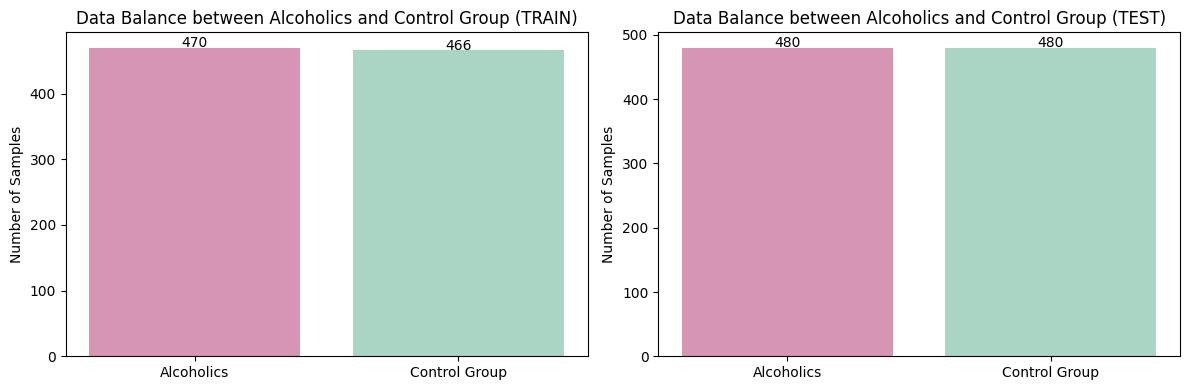

In [10]:
import matplotlib.pyplot as plt

train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
train_class_counts = [sum(train_classes), len(train_classes) - sum(train_classes)]

test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]
test_class_counts = [sum(test_classes), len(test_classes) - sum(test_classes)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(['Alcoholics', 'Control Group'], train_class_counts, color=['#D695B2', '#AAD5C4'])
ax1.set_title('Data Balance between Alcoholics and Control Group (TRAIN)')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate(train_class_counts):
    ax1.text(i, v + 0.5, str(v), color='black', ha='center')

ax2.bar(['Alcoholics', 'Control Group'], test_class_counts, color=['#D695B2', '#AAD5C4'])
ax2.set_title('Data Balance between Alcoholics and Control Group (TEST)')
ax2.set_ylabel('Number of Samples')
for i, v in enumerate(test_class_counts):
    ax2.text(i, v + 0.5, str(v), color='black', ha='center')

plt.tight_layout()
plt.show()

The data appears to be balanced

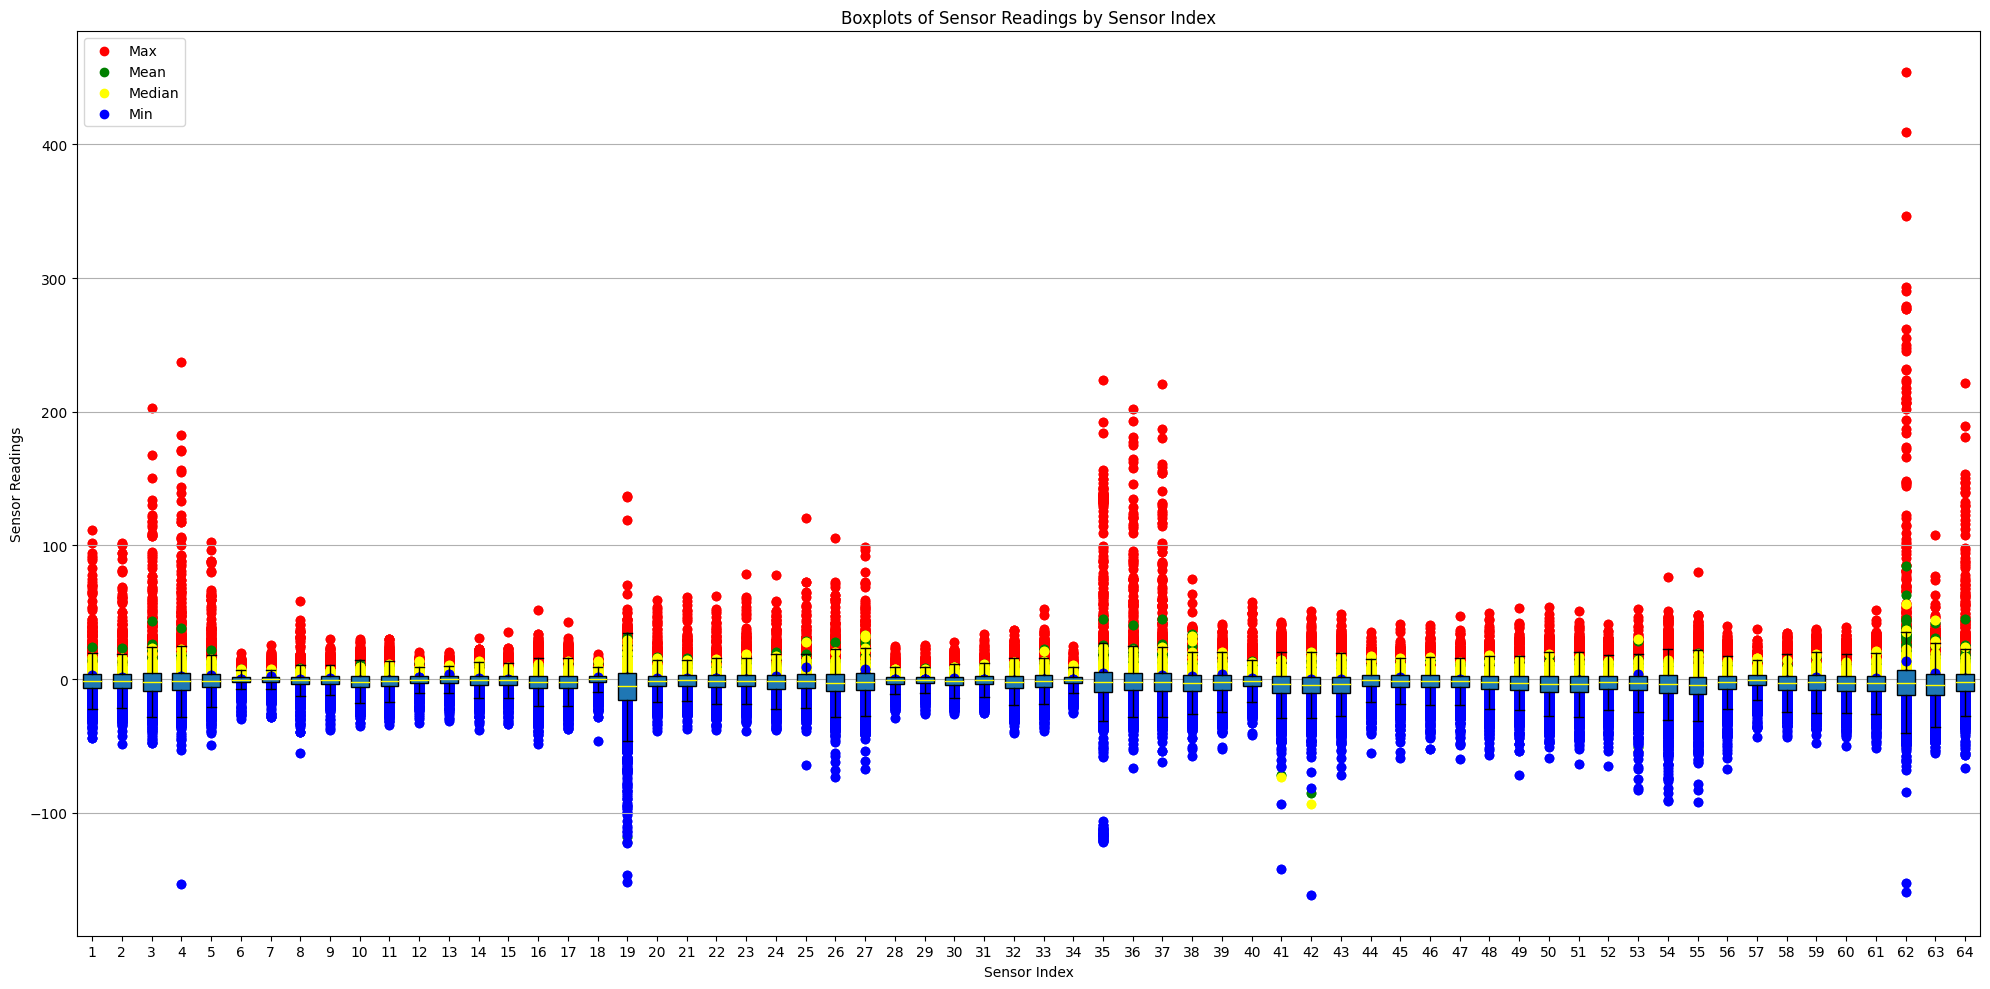

In [9]:
import matplotlib.pyplot as plt
import numpy as np

rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["time_series"].shape[1]

stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["time_series"]
    stats["mean"][i], stats["max"][i], stats["min"][i], stats["median"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0)

plt.figure(figsize=(20, 10))
positions = np.arange(1, cols + 1)

column_data = [[] for _ in range(cols)]
for key in train_data:
    for col in range(cols):
        column_data[col].extend(train_data[key]["time_series"].iloc[:, col])

boxplots = plt.boxplot(column_data, positions=positions, widths=0.6, patch_artist=True, medianprops=dict(color='yellow'), showfliers=False)

for i, pos in enumerate(positions):
    plt.scatter([pos]*rows, stats['max'][:, i], color='red', label='Max' if i == 0 else "")
    plt.scatter([pos]*rows, stats['mean'][:, i], color='green', label='Mean' if i == 0 else "")
    plt.scatter([pos]*rows, stats['median'][:, i], color='yellow', label='Median' if i == 0 else "")
    plt.scatter([pos]*rows, stats['min'][:, i], color='blue', label='Min' if i == 0 else "")

plt.title("Boxplots of Sensor Readings by Sensor Index")
plt.xlabel("Sensor Index")
plt.ylabel("Sensor Readings")
plt.grid(axis='y')

plt.legend()

plt.tight_layout()
plt.show()


In [10]:
from scipy.stats import pearsonr

In [11]:
stats.keys()

dict_keys(['mean', 'max', 'min', 'median'])

In [12]:
corr = np.empty((cols, 4))

for i_s, (stat_name, stat) in enumerate(stats.items()):
    for i_m, m in enumerate(stat.T):
        corr[i_m, i_s] = pearsonr(m, train_classes)[0]

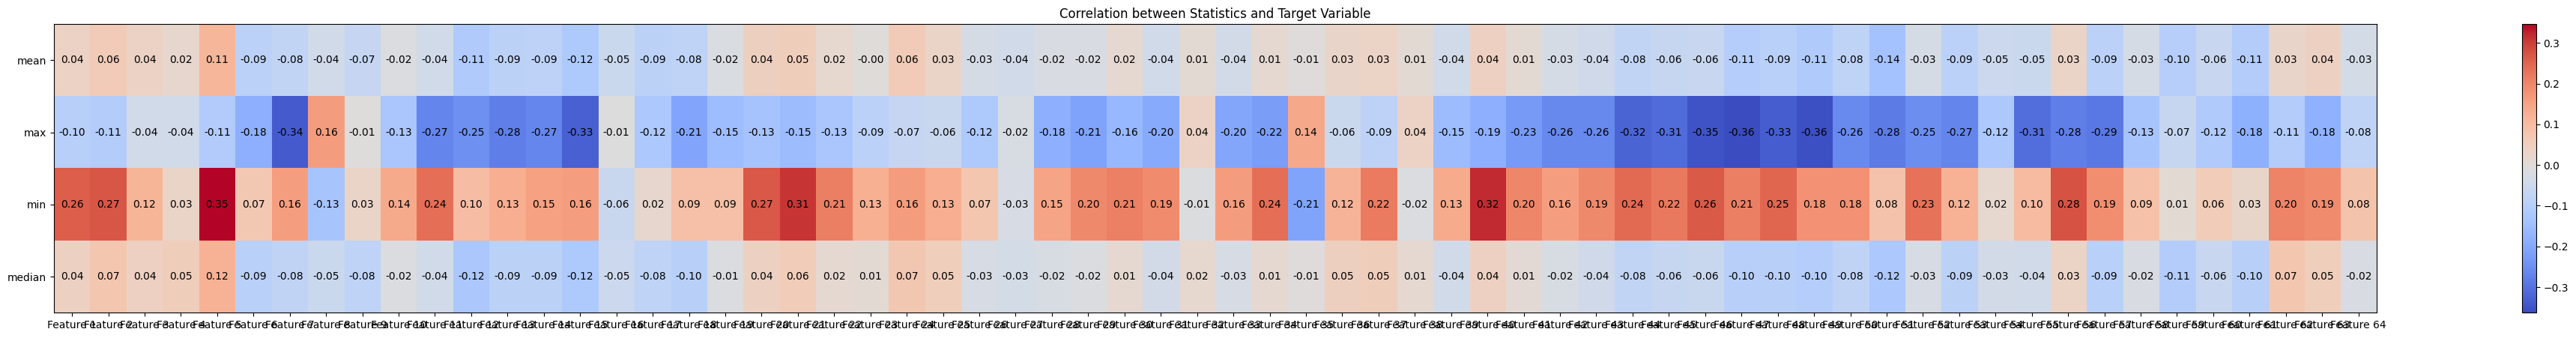

In [13]:
plt.figure(figsize=(50, 5))
plt.imshow(corr.T, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(corr.shape[0]), labels=[f"Feature {i+1}" for i in range(corr.shape[0])])  # Generalized label
plt.yticks(range(corr.shape[1]), labels=['mean', 'max', 'min', 'median'])
for x in range(corr.shape[0]):
    for y in range(corr.shape[1]):
        plt.text(x, y, f"{corr[x, y]:.2f}", ha="center", va="center", color="black")
plt.title("Correlation between Statistics and Target Variable")
plt.show()

Maxs are highly correlated, means usually don't hold much value, mins are somehow correlated but not much, medians are not very correlated (same as means).

# Simple model

In [23]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [24]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [25]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
predicted = model.predict(X_test)
f1 = f1_score(y_test, predicted)
print(f"Model Accuracy: {accuracy:.6f}")
print(f"F1 Score: {f1:.6f}")

Model Accuracy: 0.914583
F1 Score: 0.915464


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

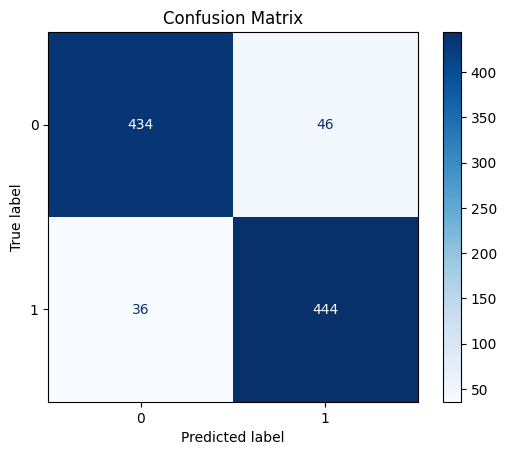

In [28]:
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# left vs right